In [142]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

## Oppgave 1


#### 1 a)

For å representere en polymer av en gitt lengde numerisk er det mulig å lagre hele gitteret, inkludert alle null-elementene, som en matrise, hvor sidelengdene er større enn polymeret. Dette er derimot ikke hensiktsmessig ettersom majoriteten av informasjonen lagret er overflødig. For å forenkle dette kan istedet kun selve posisjonen av hver monomer lagres. Polymeren representeres i et 2D kartesisk kordinatsystem, og dermed kan hver monomer posisjon beskrives av en tuppel med kordinatene x og y. Slik kan hele polymeren være representert av en N x 2 matrise.   

#### 1 b)

In [143]:
def polymer(N: int) -> list[int]:
    """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
    return [(0, i) for i in range(-N//2, N//2)]

#### 1 c)

Energien til en gitt polymer er avhengig av antall monomerer som vekselsvirker med hverandre. Reglene for denne vekselvirkningen er oppgitt i seksjon 2 av prosjektheftet. I algoritme 1 og 2, som begge er Monte Carlo-metoder, velges tilfeldig en monomer som roteres om. Ettersom rotasjon i endemonomerene ikke endrer formen av polymeret, men heller kun roterer hele polymeret, vil det heller ikke oppstå noen endring av energien i polymeret. Dermed er det ikke hensiktsmessig å inkludere endemonomerene i utvalget den tilfeldige monomeren trekkes fra. 

#### 1 d)

In [190]:
# Method to display the polymer
def display_polymer(polymer_list: list[int]) -> None:
    """
    Function that displays the polymer in a grid
    :param polymer_list: list[int]
    :return: None
    """
    # Adjust grid boundaries to include all monomers
    grid_size = 2 * len(polymer_list) + 1
    offset = len(polymer_list)
    x = np.linspace(-offset, offset, grid_size)
    X, Y = np.meshgrid(x, x)
    
    Z = np.zeros(X.shape)

    # Calculate intensity values for each monomer (stronger towards the end)
    for i, (x, y) in enumerate(polymer_list):
        intensity = i / (len(polymer_list) - 1) + 0.05
        Z[x + offset, y + offset] = intensity

    # Define a purple colormap
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "purple"])

    plt.pcolormesh(X, Y, Z, cmap=cmap)
    plt.show()

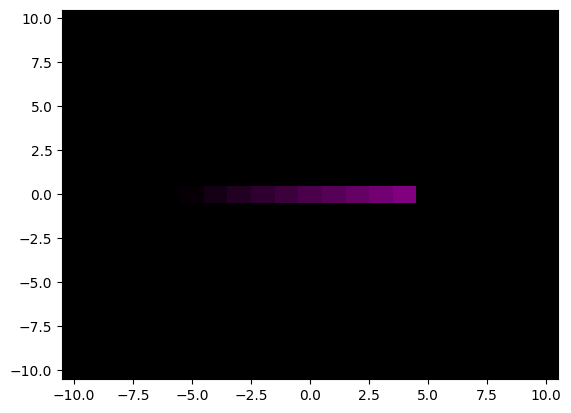

In [191]:
# Test the new Polymer function and display function
polymer_list = polymer(10)

display_polymer(polymer_list)


#### 1 e)

We added our own criteria, we make it a requirement that no monomer can share coordinates with another, thus it cannot be on top of itself

In [146]:
def is_intact_polymer(polymer_object: list[int], N: int) -> bool:
    """
    Function that checks if the polymer is intact
    :param polymer_object: list[int]
    :param N: int
    :return: bool
    """

    # Check if the polymer is the right length
    if len(polymer_object) != N:
        return False

    # Go through each monomer and check if it has a neighbor
    for i in range(N):
        # Hvis det ikke er den første monomeren, sjekk forrige nabo
        if i > 0 and not (abs(polymer_object[i][0] - polymer_object[i-1][0]) == 1 and polymer_object[i][1] == polymer_object[i-1][1]) and not (polymer_object[i][0] == polymer_object[i-1][0] and abs(polymer_object[i][1] - polymer_object[i-1][1]) == 1):
            return False
        
        # If it is not the last monomer, check next neighbor
        if i < N - 1 and not (abs(polymer_object[i][0] - polymer_object[i+1][0]) == 1 and polymer_object[i][1] == polymer_object[i+1][1]) and not (polymer_object[i][0] == polymer_object[i+1][0] and abs(polymer_object[i][1] - polymer_object[i+1][1]) == 1):
            return False
        
        # Check if the monomer is on top of another monomer\n",
        if polymer_object.count(polymer_object[i]) > 1:
            return False
    return True

#### 1f)

In [147]:
def rotate_polymer(polymer_object: list[int], xy_val: tuple[int, int], counter_clockwise: bool) -> list[int]:
    """
    Function that rotates the smaller half of the polymer around a point with 90 degrees
    :param polymer_object: list[int]
    :param xy_val: tuple[int, int]
    :param counter_clockwise: bool
    :return: list[int]
    """
    rotated_polymer = []
    rotation_index = polymer_object.index(xy_val)

    # Determine which half to rotate (smaller half or front half if in the middle)
    if rotation_index <= len(polymer_object) // 2:
        # Rotate the front half
        polymer_to_rotate = polymer_object[:rotation_index + 1]
        polymer_remaining = polymer_object[rotation_index + 1:]
    else:
        # Rotate the back half
        polymer_to_rotate = polymer_object[rotation_index:]
        polymer_remaining = polymer_object[:rotation_index]

    # Apply rotation to the chosen half
    for x, y in polymer_to_rotate:
        dx, dy = x - xy_val[0], y - xy_val[1]
        if counter_clockwise:
            new_x, new_y = xy_val[0] - dy, xy_val[1] + dx
        else:
            new_x, new_y = xy_val[0] + dy, xy_val[1] - dx
        rotated_polymer.append((new_x, new_y))

    # Combine the rotated half with the unrotated half
    if rotation_index <= len(polymer_object) // 2:
        rotated_polymer.extend(polymer_remaining)
    else:
        rotated_polymer = polymer_remaining + rotated_polymer

    return rotated_polymer

In [148]:
"""
def polymer_energy(polymer_object: list[int]) -> float:
    #
    #Function that calculates the energy of the polymer
    #:param polymer_object: list[int]
    #:return: float
    #
    energy = 0
    for i in range(len(polymer_object)):
        for j in range(i+1, len(polymer_object)):
            if polymer_object[i][0] == polymer_object[j][0] and abs(polymer_object[i][1] - polymer_object[j][1]) == 1:
                energy += 1
            if polymer_object[i][1] == polymer_object[j][1] and abs(polymer_object[i][0] - polymer_object[j][0]) == 1:
                energy += 1
    return energy
    """

'\ndef polymer_energy(polymer_object: list[int]) -> float:\n    #\n    #Function that calculates the energy of the polymer\n    #:param polymer_object: list[int]\n    #:return: float\n    #\n    energy = 0\n    for i in range(len(polymer_object)):\n        for j in range(i+1, len(polymer_object)):\n            if polymer_object[i][0] == polymer_object[j][0] and abs(polymer_object[i][1] - polymer_object[j][1]) == 1:\n                energy += 1\n            if polymer_object[i][1] == polymer_object[j][1] and abs(polymer_object[i][0] - polymer_object[j][0]) == 1:\n                energy += 1\n    return energy\n    '

#### 1g)

In [149]:
def algorithm1(N: int, Ns: int) -> (list[int], int):
    counter = 0
    polymer_object = polymer(N)

    for _ in range(Ns):
        # Choose a random monomer
        random_monomer_index = np.random.randint(0, N)
        random_monomer = polymer_object[random_monomer_index]

        # Randomly choose rotation direction
        rotate_clockwise = np.random.choice([True, False])

        # Rotate the polymer
        rotated_polymer = rotate_polymer(polymer_object, random_monomer, not rotate_clockwise)

        # Check if the rotated polymer is intact
        if is_intact_polymer(rotated_polymer, N):
            counter += 1
            polymer_object = rotated_polymer

    return polymer_object, counter


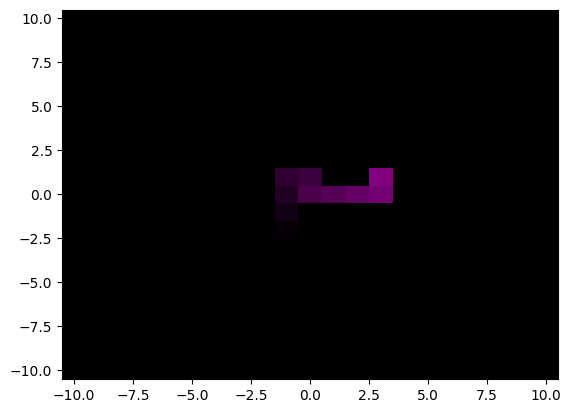

12


In [322]:
tester_, count = algorithm1(10, 15)
display_polymer(tester_)
print(count)

#### 1h)

## Oppgave 2